In [22]:
# Path setup
import sys
import os

sys.path.append("/home/dchen/Random_Forest_Weights/")

# Basics:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Helpful:
from sklearn.model_selection import train_test_split

# Pipeline and ColumnsTransformer:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error
# models:
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

# my functions:
from src_rf.methods.calc_mean import *
from src_rf.methods.calc_weights import *
from src_rf.methods.calc_dist import *

### 1. Load Data

In [2]:
df = pd.read_csv("/home/dchen/Random_Forest_Weights/src_rf/data/energy_data_hourly.csv"
                 , index_col = 'datetime', parse_dates=True)

### 2. Train Test Split


#### 2.1 Data 1:

In [37]:
X = df.drop(['total_energy_usage'], axis = 1)
y = df['total_energy_usage']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3 ,shuffle=False, random_state=42)

#### 2.2 Data 2:

In [39]:
df2 = df.copy(deep=True)
df2.index = pd.to_datetime(df2.index)

# Data manipulation to purely time series:
df2.drop(['residual_energy_usage', 'pump_storage'], inplace=True, axis=1)

# Extract the year from the index
df2['Year2'] = df2.index.year

year_dummies2 = pd.get_dummies(df2['Year2'], prefix='Year')
month_dummies2 = pd.get_dummies(df2['month'], prefix='Month')
hour_dummies2 = pd.get_dummies(df2['hour'], prefix='Hour')

# Drop the original columns and join with dummy variables
df2 = df2.drop(['Year2', 'month', 'hour'], axis=1)
df2 = df2.join([year_dummies2, month_dummies2, hour_dummies2])

df2['Count2'] = range(0, df2.shape[0])

# 2. Train Test Split for df2:
X2 = df2.drop('total_energy_usage', axis=1).values
y2 = df2['total_energy_usage'].values

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, shuffle=False, random_state=42)

### 3. Model Training

In [21]:
bootstrap = True
max_samples = 0.5
n_estimators = 300
min_samples_split = 5
min_samples_leaf = 5
max_depth = 40

rf = RandomForestRegressor(
    bootstrap=bootstrap,
    max_samples=max_samples,
    n_estimators=n_estimators,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_depth=max_depth,
    random_state=42,
    n_jobs=-2
)
bootstrap = True  # From the results you provided
max_samples = 0.3  # From the results
n_estimators = 700  # From the results
min_samples_split = 7  # From the results
min_samples_leaf = 5  # From the results
max_depth = 50  # From the results


rf_2 = RandomForestRegressor(
    bootstrap=bootstrap,
    max_samples=max_samples,
    n_estimators=n_estimators,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_depth=max_depth,
    random_state=42,
    n_jobs=-2
)

In [22]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=40, max_samples=0.5, min_samples_leaf=5,
                      min_samples_split=5, n_estimators=300, n_jobs=-2,
                      random_state=42)

In [23]:
rf_2.fit(X_train2, y_train2)

RandomForestRegressor(max_depth=50, max_samples=0.3, min_samples_leaf=5,
                      min_samples_split=7, n_estimators=700, n_jobs=-2,
                      random_state=42)

### 4. Scores

In [28]:
# Predictions for the original model and dataset
y_pred = rf.predict(X_test)

# Predictions for the modified model and dataset
y_pred2 = rf_2.predict(X_test2)

# Evaluation for the original model and dataset
r2_original = r2_score(y_test, y_pred)
mae_original = mean_absolute_error(y_test, y_pred)

# Evaluation for the modified model and dataset
r2_modified = r2_score(y_test2, y_pred2)
mae_modified = mean_absolute_error(y_test2, y_pred2)

# Print the results
print("Original Dataset:")
print(f"R2: {r2_original:.2f}")
print(f"Mean Absolute Error: {mae_original:.2f}")
print("\nModified Dataset:")
print(f"R2: {r2_modified:.2f}")
print(f"Mean Absolute Error: {mae_modified:.2f}")

Original Dataset:
R2: 0.87
Mean Absolute Error: 2.45

Modified Dataset:
R2: 0.47
Mean Absolute Error: 5.43


### 5. Feature Importance

#### 5.1 Random Forest 1

In [24]:
feature_importances = rf.feature_importances_
# Get feature names (assuming X is a DataFrame)
features = X.columns
sorted_idx = feature_importances.argsort()

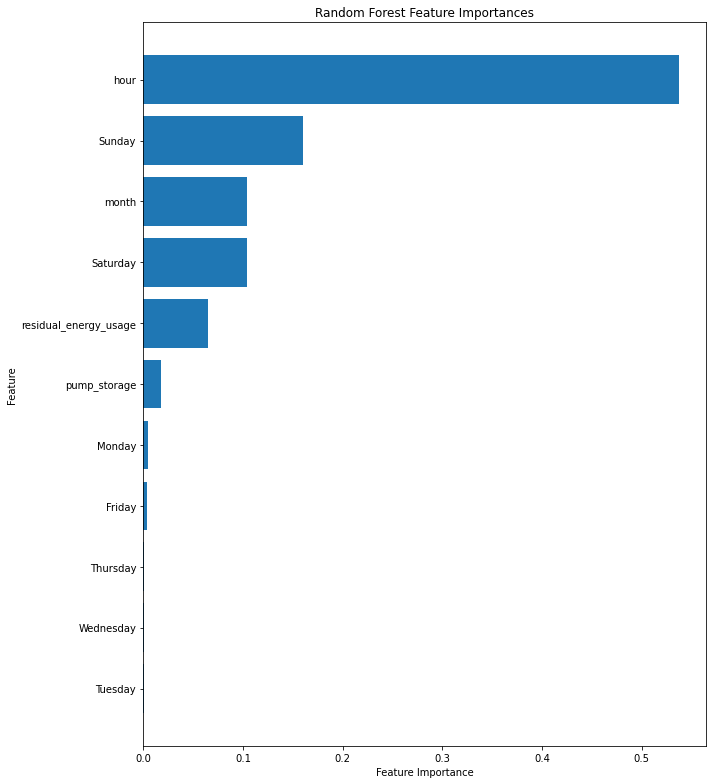

In [25]:
plt.figure(figsize=(10, len(features)))

plt.barh(features[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

#### 5.2 Random Forest 2:

In [26]:
feature_importances2 = rf_2.feature_importances_
# Assuming df2 is a DataFrame, get the feature names
features2 = df2.drop('total_energy_usage', axis=1).columns
sorted_idx2 = feature_importances2.argsort()

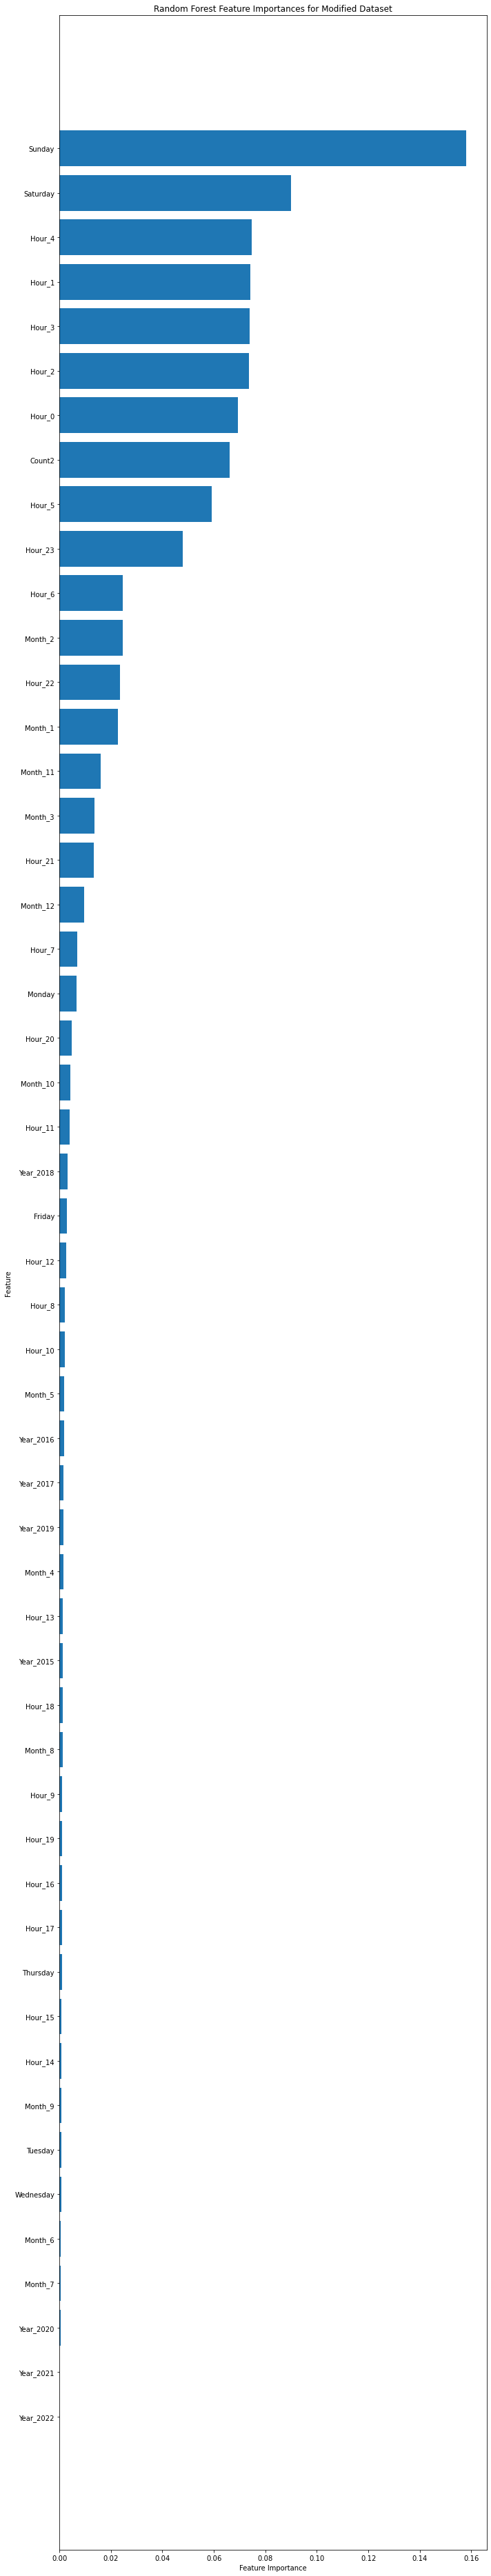

In [27]:
plt.figure(figsize=(10, len(features2)))

plt.barh(features2[sorted_idx2], feature_importances2[sorted_idx2])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances for Modified Dataset")
plt.tight_layout()
plt.show()